<a href="https://colab.research.google.com/github/Voloodya/multiclass_Unet_segm_models_ensemble_2D/blob/main/multiclass_Unet_segm_models_ensemble_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Мультиклассовая семантическая сегментация с использованием U-Net**

Ансамбль сетей для повышения точности глубокого обучения

In [ ]:
!python3 --version

Python 3.7.10


In [ ]:
!pip3 --version

pip 19.3.1 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)


In [ ]:
!pip install -U -q segmentation-models
!pip install -U --pre segmentation-models

In [ ]:
!pip install -U albumentations

In [ ]:
#!pip install gast==0.3.2

In [ ]:
!pip install -q tensorflow==2.1
!pip install -q keras==2.3.1
!pip install -q tensorflow-estimator==2.1

In [ ]:
!pip uninstall h5py

In [ ]:
!pip install -q h5py==2.10.0

In [ ]:
#!pip install te

In [6]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [ ]:
#import keras as keras
#print(keras.__version__)

In [ ]:
#!pip uninstall tensorflow -y
#!pip uninstall tensorflow-estimator -y
#!pip install tensorflow-estimator==2.1.0

In [ ]:
#!pip install tensorflow==2.1.0

In [ ]:
#!pip install keras==2.3.1

In [ ]:
!pip install patchify

In [7]:
!pip install -U -q scikit-learn

     |████████████████████████████████| 22.3MB 1.8MB/s 


In [8]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [9]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
#import keras 
from tensorflow import keras

#from keras import normalize
from tensorflow.keras.utils import normalize
#from keras.metrics import MeanIoU
from tensorflow.keras.metrics import MeanIoU

Segmentation Models: using `tf.keras` framework.


In [12]:
#pip install patchify
#patchify библиотека для работы с большими изображениями
# Можно использовать patchify, чтобы разбить большие объемы на меньшие для обучения
# а также собрать исправления после предсказания.
from patchify import patchify, unpatchify

**Монтирование диска**

In [13]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


**Копирование с монтированного диска на машину**

In [ ]:
!pwd

/content


In [ ]:
!mkdir sandstone
!mkdir Train_masks

mkdir: cannot create directory ‘Train_masks’: File exists


In [ ]:
!cp /content/gdrive/"My Drive"/Image_dataset/all_images/Train_images/*.tif '/content/Train_images/'
!cp  /content/gdrive/"My Drive"/Image_dataset/all_images/Train_masks/*.tif '/content/Train_masks/'

**Копирование с машины на смонтированный диск**

In [ ]:
!cp '...' /content/gdrive/"My Drive"/...
!cp '...' /content/gdrive/"My Drive"/...

cp: cannot stat '/Train_images': No such file or directory
cp: cannot stat '/Train_masks': No such file or directory


Resizing images, if needed

In [14]:
SIZE_X = 128 
SIZE_Y = 128

In [15]:
n_classes=4 #Number of classes for segmentation

In [ ]:
image_directory='/content/Train_images/'
mask_directory='/content/Train_masks/'

In [ ]:
images=os.listdir(image_directory)
masks_images=os.listdir(mask_directory)

Сохранение информации об обучающем образе в виде списка

In [16]:
train_images = []

In [17]:
for directory_path in glob.glob('/content/gdrive/My Drive/Image_dataset/sandstone/images_train_128_patches_stone'):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.tif"))):
        #Считывание изображения в (RGB-1)
        img = cv2.imread(img_path, 1)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)

Преобразовать список в массив для обработки

In [18]:
train_images = np.array(train_images)

In [19]:
print(train_images.shape)
IMG_HEIGHT = train_images.shape[1]
IMG_WIDTH  = train_images.shape[2]
IMG_CHANNELS = train_images.shape[3]

(1600, 128, 128, 3)


**Получение информации о маске / метке в виде списка**

In [20]:
train_masks = [] 
for directory_path in glob.glob('/content/gdrive/My Drive/Image_dataset/sandstone/masks_train_128_patches_stone'):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.tif"))):
        #Считывание изображения в оттенках серого
        mask = cv2.imread(mask_path, 0)       
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)

Преобразовать список в массив для обработки

In [21]:
train_masks = np.array(train_masks)
print(train_masks.shape)

(1600, 128, 128)


In [22]:
IMG_HEIGHT = train_masks.shape[1]
IMG_WIDTH  = train_masks.shape[2]
#IMG_CHANNELS = train_masks.shape[3]

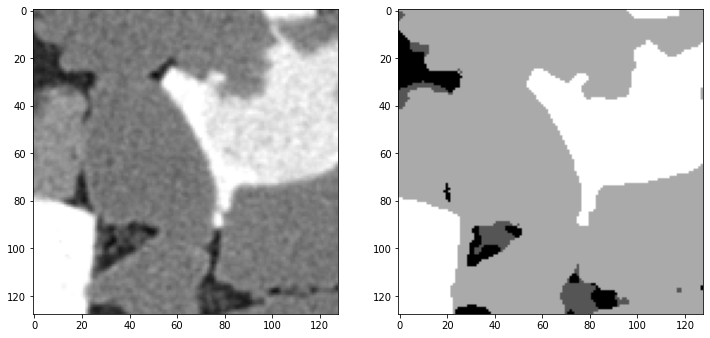

In [ ]:
import random
import numpy as np
image_number = random.randint(0, len(train_images))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(train_images[image_number], (128, 128,3)))
#plt.imshow(X_train[image_number])
plt.subplot(122)
plt.imshow(np.reshape(train_masks[image_number], (128, 128)), cmap='gray')
#plt.imshow(y_train[image_number])
plt.show()

###############################################

Кодирование меток ... но многотомный массив, поэтому необходимо сглаживать, кодировать и изменять форму

In [23]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
# Возвращает размерности массивов (уровней массивов)
number_images, height, width = train_masks.shape
print("Размерности массивов: ", train_masks.shape)
print("Class values in the dataset are ... ", np.unique(train_masks))
# Изменение представления массива (перестройка уровней)
train_masks_reshaped = train_masks.reshape(-1,1)
print("Размерности массивов: ", train_masks_reshaped.shape)
#Преобразования категориальных или текстовых данных в числа.
#Нормализует метки таким образом, чтобы они содержали только значения от 0 до n_classes-1
#Tакже можно использовать для преобразования нечисловых меток (если они хешируемы и сопоставимы) в числовые метки
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(number_images, height, width)
print("Class values in the dataset are ... ", np.unique(train_masks_encoded_original_shape))

Размерности массивов:  (1600, 128, 128)
Class values in the dataset are ...  [1 2 3 4]
Размерности массивов:  (26214400, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Class values in the dataset are ...  [0 1 2 3]


#################################################

In [ ]:
print(train_images.shape)

(1600, 128, 128, 3)


**Добавление меток классов в массив с масками**

In [24]:
#train_images = np.expand_dims(train_images, axis=3)
#train_images = normalize(train_images, axis=1)
# Добавление измерения в массив NumPy, чтобы затем можно было увеличить это измерение для размещения новых данных
#image = np.expand_dims(image, <your desired dimension>)
#Добавляем измерение с кодом класса маски
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
print(train_masks_input.shape)

(1600, 128, 128, 1)


Создание подмножества данных для быстрого тестирования
Выбираем 10% на тестирование, а остальные на обучение

In [25]:
#pip3 install -U scikit-learn scipy matplotlib
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

Дальнейшее разделение обучающих данных на меньшее подмножество для быстрого тестирования моделей

In [26]:
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # Уникальные маскм (0 is the background/few unlabeled)
print(X_train.shape)
print(y_train.shape)

Class values in the dataset are ...  [0 1 2 3]
(720, 128, 128, 3)
(720, 128, 128, 1)


Просмотр соответствия

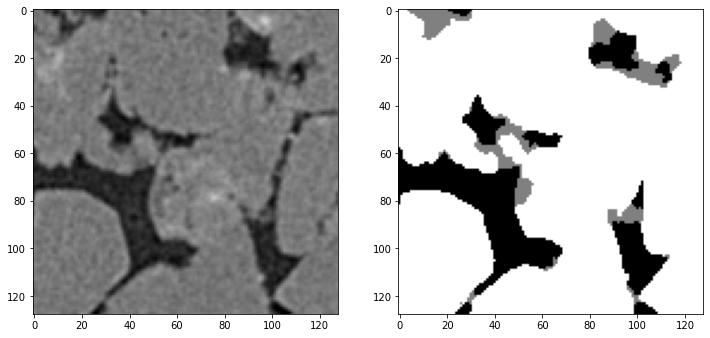

In [ ]:
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (128, 128,3)))
#plt.imshow(X_train[image_number])
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (128, 128)), cmap='gray')
#plt.imshow(y_train[image_number])
plt.show()

############################################################################################

In [27]:
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
#keras.utils.to_categorical(y, num_classes=None, dtype=’float32′)
#Преобразует вектор класса (целые числа) в двоичную классную матрицу.
#y: вектор класса, который будет преобразован в матрицу (целые числа от 0 до num_classes).
#num_classes: общее количество классов.
#dtype: Тип данных, ожидаемый на входе, как строка (float32, float64, int32…).
# 0 -> [0,0,0,0]; 1 -> [1,0,0,0], ...
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))


test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

Проверка сбалансированности набора данных (данных где преобладает 1-н класс)

In [28]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_masks_reshaped_encoded),
                                                 train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3], y=[2 2 2 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Class weights are...: [1.93354786 3.07345989 0.32786918 9.30640739]


######################################################

**Параметры для всех моделей**

**Softmax** — это обобщение логистической функции для многомерного случая. Функция преобразует вектор z размерности K в вектор sigma  той же размерности, где каждая координата sigma{i} полученного вектора представлена вещественным числом в интервале [0,1] и сумма координат равна 1.

**Adam** — adaptive moment estimation, градиентный оптимизационный алгоритм. Он сочетает в себе и идею накопления движения и идею более слабого обновления весов для типичных признаков.

In [29]:
n_classes=4
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

Потери в моделях сегментации можно объединить знаком «+» и масштабировать с помощью целого числа или коэффициента с плавающей запятой.

In [30]:
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [31]:
# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)] # tf.metrics.SensitivityAtSpecificity(0.5)

########################################################################

# **Model 1**

In [32]:
BACKBONE1 = 'resnet34'
# Получаем предобработку для данной сети
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

print(X_train1.shape)
print(X_test1.shape)
print(y_test_cat.shape)

(720, 128, 128, 3)
(160, 128, 128, 3)
(160, 128, 128, 4)


In [ ]:
# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model1.summary())

85524480/85521592 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
___________________________

In [ ]:
history1=model1.fit(X_train1, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test1, y_test_cat))


model1.save('res34_backbone_50epochs.hdf5')

Train on 720 samples, validate on 160 samples
Epoch 1/50
720/720 [==============================] - 19s 26ms/sample - loss: 0.9593 - iou_score: 0.2660 - f1-score: 0.3641 - val_loss: 0.9579 - val_iou_score: 0.2019 - val_f1-score: 0.3044
Epoch 2/50
720/720 [==============================] - 6s 8ms/sample - loss: 0.8915 - iou_score: 0.5898 - f1-score: 0.7053 - val_loss: 0.9405 - val_iou_score: 0.3602 - val_f1-score: 0.4995
Epoch 3/50
720/720 [==============================] - 6s 8ms/sample - loss: 0.8539 - iou_score: 0.7100 - f1-score: 0.8129 - val_loss: 0.8996 - val_iou_score: 0.5179 - val_f1-score: 0.6312
Epoch 4/50
720/720 [==============================] - 6s 8ms/sample - loss: 0.8268 - iou_score: 0.7739 - f1-score: 0.8620 - val_loss: 0.8652 - val_iou_score: 0.6337 - val_f1-score: 0.7490
Epoch 5/50
720/720 [==============================] - 6s 8ms/sample - loss: 0.8123 - iou_score: 0.7985 - f1-score: 0.8803 - val_loss: 0.8247 - val_iou_score: 0.7505 - val_f1-score: 0.8448
Epoch 6/50
7

Сохранение модели на google-диск

In [ ]:
!cp 'res34_backbone_50epochs.hdf5' /content/gdrive/"My Drive"/Computer_vision

############################################################

# **Model 2**

In [34]:
BACKBONE2 = 'inceptionv3'
# Получаем предобработку для данной сети
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

In [ ]:
# define model
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=n_classes, activation=activation)


# compile keras model with defined optimozer, loss and metrics
model2.compile(optim, total_loss, metrics)
#model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


print(model2.summary())

87916544/87910968 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
___________________________

In [ ]:
history2=model2.fit(X_train2, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test2, y_test_cat))


model2.save('inceptionv3_backbone_50epochs.hdf5')

Train on 720 samples, validate on 160 samples
Epoch 1/50
720/720 [==============================] - 20s 28ms/sample - loss: 0.8692 - iou_score: 0.6175 - f1-score: 0.7080 - val_loss: 0.9856 - val_iou_score: 0.3579 - val_f1-score: 0.4713
Epoch 2/50
720/720 [==============================] - 8s 11ms/sample - loss: 0.8023 - iou_score: 0.8068 - f1-score: 0.8844 - val_loss: 0.8191 - val_iou_score: 0.7474 - val_f1-score: 0.8409
Epoch 3/50
720/720 [==============================] - 8s 11ms/sample - loss: 0.7890 - iou_score: 0.8380 - f1-score: 0.9053 - val_loss: 0.8108 - val_iou_score: 0.7396 - val_f1-score: 0.8368
Epoch 4/50
720/720 [==============================] - 8s 12ms/sample - loss: 0.7828 - iou_score: 0.8571 - f1-score: 0.9187 - val_loss: 0.7959 - val_iou_score: 0.7911 - val_f1-score: 0.8750
Epoch 5/50
720/720 [==============================] - 8s 11ms/sample - loss: 0.7804 - iou_score: 0.8649 - f1-score: 0.9233 - val_loss: 0.7850 - val_iou_score: 0.8330 - val_f1-score: 0.9037
Epoch 6/

Сохранение модели на google-диск

In [ ]:
!cp 'inceptionv3_backbone_50epochs.hdf5' /content/gdrive/"My Drive"/Computer_vision

#####################################################

# **Model 3**

In [35]:
BACKBONE3 = 'vgg16'
# Получаем предобработку для данной сети
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

# preprocess input
X_train3 = preprocess_input3(X_train)
X_test3 = preprocess_input3(X_test)

In [ ]:
# define model
model3 = sm.Unet(BACKBONE3, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model3.compile(optim, total_loss, metrics)
#model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


print(model3.summary())

58892288/58889256 [==============================] - 1s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
___________________________

In [ ]:
history3=model3.fit(X_train3, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test3, y_test_cat))

model2.save('vgg19_backbone_50epochs.hdf5')

Train on 720 samples, validate on 160 samples
Epoch 1/50
720/720 [==============================] - 8s 11ms/sample - loss: 0.7582 - iou_score: 0.9573 - f1-score: 0.9780 - val_loss: 0.7659 - val_iou_score: 0.9175 - val_f1-score: 0.9558
Epoch 2/50
720/720 [==============================] - 8s 11ms/sample - loss: 0.7579 - iou_score: 0.9585 - f1-score: 0.9786 - val_loss: 0.7655 - val_iou_score: 0.9205 - val_f1-score: 0.9574
Epoch 3/50
720/720 [==============================] - 8s 11ms/sample - loss: 0.7579 - iou_score: 0.9592 - f1-score: 0.9789 - val_loss: 0.7652 - val_iou_score: 0.9216 - val_f1-score: 0.9581
Epoch 4/50
720/720 [==============================] - 8s 11ms/sample - loss: 0.7575 - iou_score: 0.9609 - f1-score: 0.9799 - val_loss: 0.7652 - val_iou_score: 0.9217 - val_f1-score: 0.9581
Epoch 5/50
720/720 [==============================] - 8s 11ms/sample - loss: 0.7574 - iou_score: 0.9614 - f1-score: 0.9801 - val_loss: 0.7654 - val_iou_score: 0.9210 - val_f1-score: 0.9577
Epoch 6/5

Сохранение модели на google-диск

In [ ]:
!cp 'vgg19_backbone_50epochs.hdf5' /content/gdrive/"My Drive"/Computer_vision

##########################################################

###

Построение графиков точности и потерь обучения и проверки для каждой эпохи **resnet34**

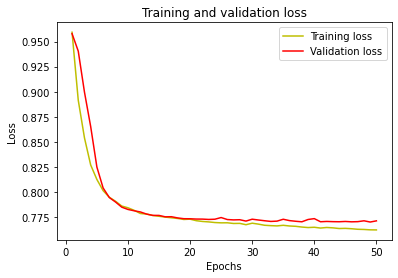

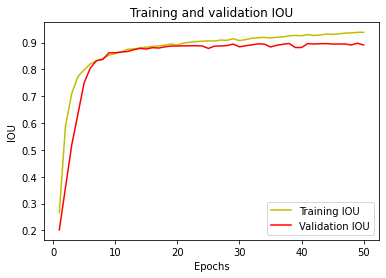

In [ ]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

Построение графиков точности и потерь обучения и проверки для каждой эпохи **inceptionv3**

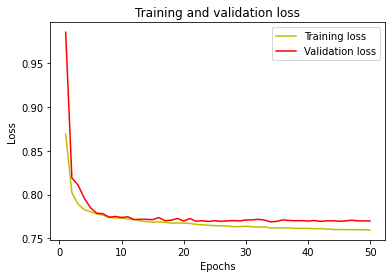

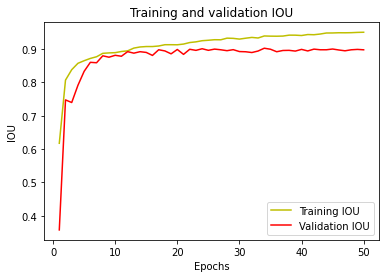

In [ ]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

Построение графиков точности и потерь обучения и проверки для каждой эпохи **vgg16**

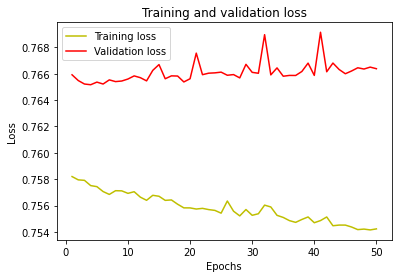

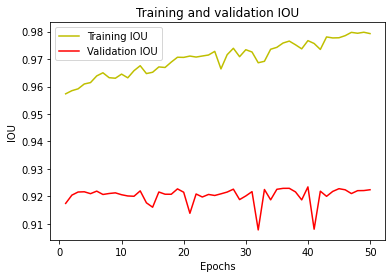

In [ ]:
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

Расчет IUO для **resnet34** для каждого класса

In [ ]:
#IOU
y_pred=model1.predict(X_test1)
y_pred_argmax=np.argmax(y_pred, axis=3)

Mean IoU = 0.9000162
[[3.306090e+05 1.805100e+04 8.090000e+03 2.000000e+00]
 [6.830000e+03 1.791950e+05 1.568200e+04 0.000000e+00]
 [3.544000e+03 1.386500e+04 1.982365e+06 5.360000e+02]
 [5.000000e+00 0.000000e+00 2.348000e+03 6.031800e+04]]
IoU for class1 is:  0.9005205226472295
IoU for class2 is:  0.767026362986521
IoU for class3 is:  0.9782548619986874
IoU for class4 is:  0.9542628423167587


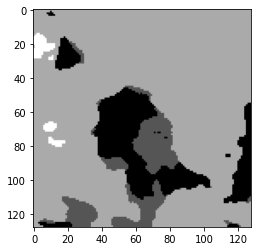

In [ ]:
#Using built in keras function
from tensorflow.keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

Расчет IUO для  **inceptionv3** для каждого класса

In [ ]:
#IOU
y_pred=model2.predict(X_test2)
y_pred_argmax=np.argmax(y_pred, axis=3)

Mean IoU = 0.9040451
[[3.355400e+05 1.544000e+04 5.772000e+03 0.000000e+00]
 [8.141000e+03 1.784840e+05 1.508200e+04 0.000000e+00]
 [5.166000e+03 1.478300e+04 1.979485e+06 8.760000e+02]
 [0.000000e+00 0.000000e+00 1.584000e+03 6.108700e+04]]
IoU for class1 is:  0.9067202797391767
IoU for class2 is:  0.7695597809683956
IoU for class3 is:  0.9786117697310787
IoU for class4 is:  0.9612884951295891


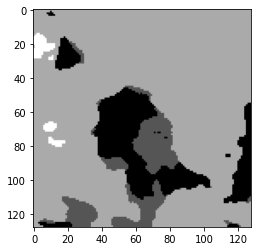

In [ ]:
#Using built in keras function
from tensorflow.keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

Расчет IUO для  **vgg16** для каждого класса

In [ ]:
#IOU
y_pred=model3.predict(X_test3)
y_pred_argmax=np.argmax(y_pred, axis=3)

Mean IoU = 0.92770875
[[3.455920e+05 6.680000e+03 4.478000e+03 2.000000e+00]
 [9.537000e+03 1.814670e+05 1.070300e+04 0.000000e+00]
 [5.375000e+03 1.022800e+04 1.984056e+06 6.510000e+02]
 [0.000000e+00 0.000000e+00 1.424000e+03 6.124700e+04]]
IoU for class1 is:  0.92985061776228
IoU for class2 is:  0.8300757038629554
IoU for class3 is:  0.9837082871613331
IoU for class4 is:  0.9672004295369844


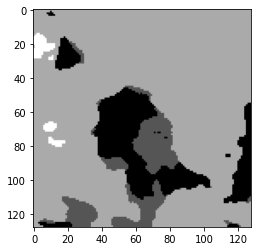

In [ ]:
#Using built in keras function
from tensorflow.keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

############################################################################

Проверим предсказание **resnet34** на наскольких изображениях

In [36]:
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model1.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

NameError: ignored

##############################################################################

#####################################################

In [37]:
from tensorflow.keras.models import load_model

#Set compile=False as we are not loading it for training, only for prediction.
model1 = load_model('/content/gdrive/My Drive/Computer_vision/res34_backbone_50epochs.hdf5', compile=False)
model2 = load_model('/content/gdrive/My Drive/Computer_vision/inceptionv3_backbone_50epochs.hdf5', compile=False)
model3 = load_model('/content/gdrive/My Drive/Computer_vision/vgg19_backbone_50epochs.hdf5', compile=False)

In [38]:
#Weighted average ensemble
models = [model1, model2, model3]
#preds = [model.predict(X_test) for model in models]

pred1 = model1.predict(X_test1)
pred2 = model2.predict(X_test2)
pred3 = model3.predict(X_test3)

preds=np.array([pred1, pred2, pred3])

In [39]:
#preds=np.array(preds)
weights = [0.3, 0.5, 0.2]

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=3)

y_pred1_argmax=np.argmax(pred1, axis=3)
y_pred2_argmax=np.argmax(pred2, axis=3)
y_pred3_argmax=np.argmax(pred3, axis=3)


#Using built in keras function
n_classes = 4
IOU1 = MeanIoU(num_classes=n_classes)  
IOU2 = MeanIoU(num_classes=n_classes)  
IOU3 = MeanIoU(num_classes=n_classes)  
IOU_weighted = MeanIoU(num_classes=n_classes)  

IOU1.update_state(y_test[:,:,:,0], y_pred1_argmax)
IOU2.update_state(y_test[:,:,:,0], y_pred2_argmax)
IOU3.update_state(y_test[:,:,:,0], y_pred3_argmax)
IOU_weighted.update_state(y_test[:,:,:,0], weighted_ensemble_prediction)


print('IOU Score for model1 = ', IOU1.result().numpy())
print('IOU Score for model2 = ', IOU2.result().numpy())
print('IOU Score for model3 = ', IOU3.result().numpy())
print('IOU Score for weighted average ensemble = ', IOU_weighted.result().numpy())

IOU Score for model1 =  0.9000162
IOU Score for model2 =  0.9040464
IOU Score for model3 =  0.08922027
IOU Score for weighted average ensemble =  0.910995


###########################################

Поиск по сетке наилучшего сочетания w1, w2, w3, дающего максимальную точность

In [40]:
import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 4):
    for w2 in range(0,4):
        for w3 in range(0,4):
            wts = [w1/10.,w2/10.,w3/10.]
            
            IOU_wted = MeanIoU(num_classes=n_classes) 
            wted_preds = np.tensordot(preds, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds, axis=3)
            IOU_wted.update_state(y_test[:,:,:,0], wted_ensemble_pred)
            print("Now predciting for weights :", w1/10., w2/10., w3/10., " : IOU = ", IOU_wted.result().numpy())
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                         'wt3':wts[2], 'IOU': IOU_wted.result().numpy()}, index=[0]), ignore_index=True)
            
max_iou_row = df.iloc[df['IOU'].idxmax()]
print("Max IOU of ", max_iou_row[3], " obained with w1=", max_iou_row[0],
      " w2=", max_iou_row[1], " and w3=", max_iou_row[2])      

Now predciting for weights : 0.0 0.0 0.0  : IOU =  0.03402252
Now predciting for weights : 0.0 0.0 0.1  : IOU =  0.08922027
Now predciting for weights : 0.0 0.0 0.2  : IOU =  0.08922027
Now predciting for weights : 0.0 0.0 0.3  : IOU =  0.08922027
Now predciting for weights : 0.0 0.1 0.0  : IOU =  0.9040464
Now predciting for weights : 0.0 0.1 0.1  : IOU =  0.09605887
Now predciting for weights : 0.0 0.1 0.2  : IOU =  0.08930728
Now predciting for weights : 0.0 0.1 0.3  : IOU =  0.089276195
Now predciting for weights : 0.0 0.2 0.0  : IOU =  0.9040464
Now predciting for weights : 0.0 0.2 0.1  : IOU =  0.9046854
Now predciting for weights : 0.0 0.2 0.2  : IOU =  0.09605887
Now predciting for weights : 0.0 0.2 0.3  : IOU =  0.08977246
Now predciting for weights : 0.0 0.3 0.0  : IOU =  0.9040464
Now predciting for weights : 0.0 0.3 0.1  : IOU =  0.90530926
Now predciting for weights : 0.0 0.3 0.2  : IOU =  0.8922085
Now predciting for weights : 0.0 0.3 0.3  : IOU =  0.09605887
Now predciti

#############################################################

In [41]:
opt_weights = [max_iou_row[0], max_iou_row[1], max_iou_row[2]]

#Use tensordot to sum the products of all elements over specified axes.
opt_weighted_preds = np.tensordot(preds, opt_weights, axes=((0),(0)))
opt_weighted_ensemble_prediction = np.argmax(opt_weighted_preds, axis=3)

#######################################################

Predict on a few images

In [42]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,:]
test_img_input=np.expand_dims(test_img_norm, 0)

#Weighted average ensemble
models = [model1, model2, model3]

test_img_input1 = preprocess_input1(test_img_input)
test_img_input2 = preprocess_input2(test_img_input)
test_img_input3 = preprocess_input3(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_pred2 = model2.predict(test_img_input2)
test_pred3 = model3.predict(test_img_input3)

test_preds=np.array([test_pred1, test_pred2, test_pred3])

Предсказание **ResNet34**:

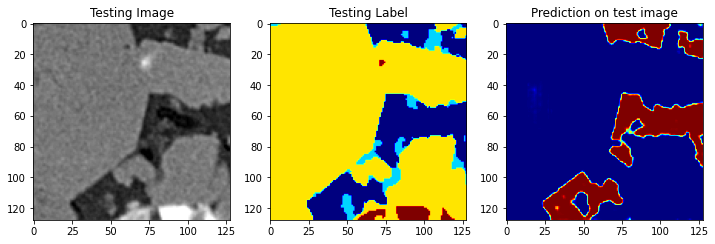

In [62]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred1[0,:,:,0], cmap='jet')
plt.show()

Предсказание **inceptionv3**:

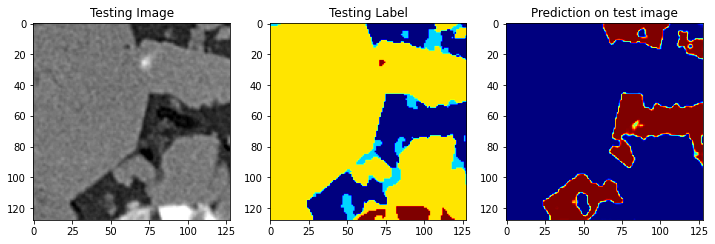

(128, 128, 1)
(1, 128, 128, 4)


In [61]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred2[0,:,:,0], cmap='jet')
plt.show()

Предсказание **vgg19**:

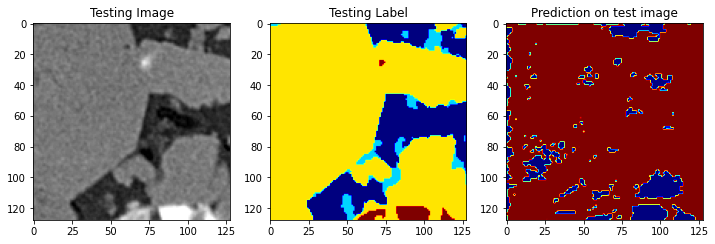

(128, 128, 1)
(1, 128, 128, 4)


In [66]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred3[0,:,:,0], cmap='jet')
plt.show()
print(ground_truth.shape)
print(test_pred2.shape)

Предсказание **ResNet34** + **inceptionv3** + **vgg19**:

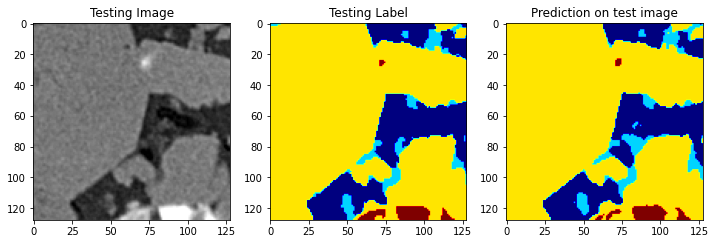

(128, 128, 1)
(128, 128)


In [60]:
#Use tensordot to sum the products of all elements over specified axes.
weighted_test_preds = np.tensordot(test_preds, opt_weights, axes=((0),(0)))
weighted_ensemble_test_prediction = np.argmax(weighted_test_preds, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(weighted_ensemble_test_prediction, cmap='jet')
plt.show()
print(ground_truth.shape)
print(weighted_ensemble_test_prediction.shape)

#####################################################################